# Investigating the $R_1$ and $R_2$ numbers introduced in Miyawaki 2022


In [10]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_sw_optical_depth
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
from scipy.interpolate import UnivariateSpline

In [2]:
exp_dir = 'tau_sweep/aquaplanet/'
var_keep = ['temp', 'sphum', 'height', 'vcomp', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe', 'ps']
tau_lw = 1
exp_dir = 'tau_sweep/aquaplanet/'
exp_name = f'k={tau_lw}'
ds = isca_tools.load_dataset(exp_dir + exp_name)[var_keep]
namelist = isca_tools.load_namelist(exp_dir + exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']

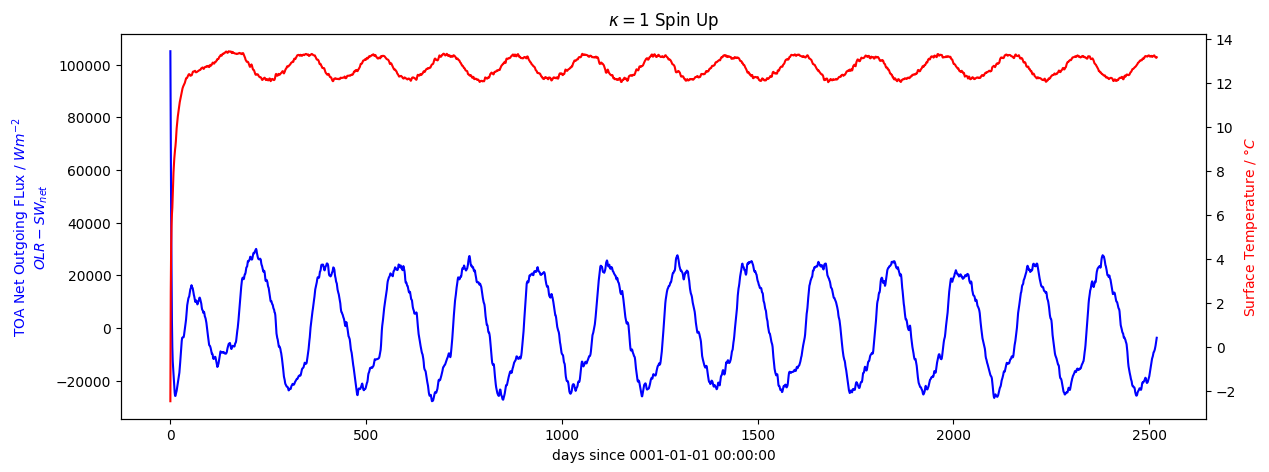

In [3]:
# Plot spin up time
fig, ax = plt.subplots(1,1, figsize=(14, 5))
isca_tools.plot.plot_spin_up(ds.olr, frierson_net_toa_sw_dwn(ds.swdn_toa, ds.ps, albedo, tau_sw),
                             ds.sel(pfull=np.inf, method="nearest").temp, ax)
plt.title(f'$\kappa = {tau_lw}$ Spin Up');

## Test Equation 1 first in the annual zonal mean
Do this so there is no $\partial_t m$ term.

In [4]:
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
# lat_use = 10
# lat_use_ind = np.argmin(np.abs(ds.lat-10).to_numpy())
# ds_use = ds.sel(lat=ds.lat[lat_use_ind-1:lat_use_ind+2])
ds_use = ds.sel(time=slice(use_time_start, np.inf))
# Need two latitudes either side of lat_use to compute meridional divergence

In [5]:
vm = (moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000 * ds_use.vcomp).mean(dim=['time', 'lon']).load()

The plot below shows what we expect i.e. MSE is transferred from the tropics to the poles, this then helps flatten out the temperature gradient.

In [6]:
vm_integ = np.asarray([integrate.simpson(vm[:,i]/g, ds.pfull*100) for i in range(ds.lat.size)])
# Fit a spline to work out the differential
cos_lat = np.asarray(np.cos(np.deg2rad(ds_use.lat)))
spl = UnivariateSpline(np.deg2rad(ds.lat), vm_integ/np.mean(np.abs(vm_integ)), s=0.2)
vm_integ_spline = spl(np.deg2rad(ds.lat)) * np.mean(np.abs(vm_integ))
vm_integ_div_spline = spl.derivative()(np.deg2rad(ds.lat)) * cos_lat/ (radius_earth * cos_lat) * np.mean(np.abs(vm_integ))
vm_integ_div = np.gradient(vm_integ * cos_lat, np.deg2rad(ds.lat))/ (radius_earth * cos_lat)

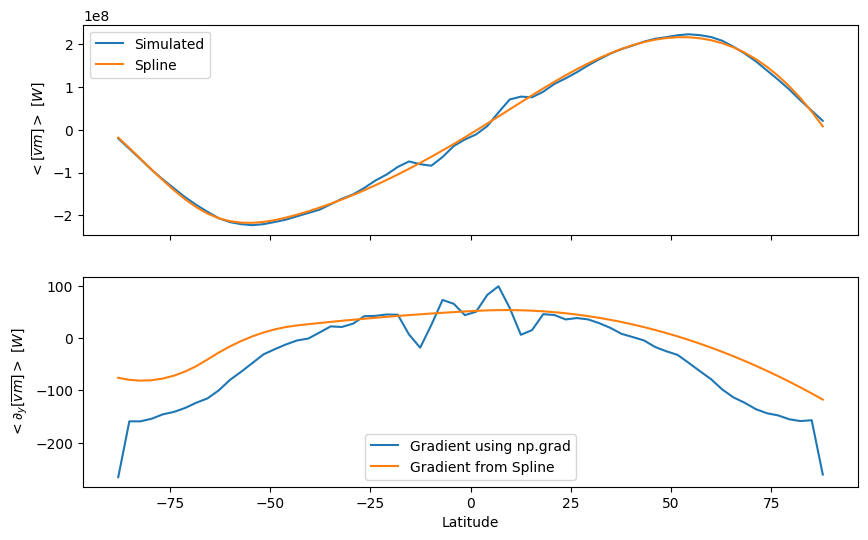

In [7]:
fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
ax[0].plot(ds.lat, vm_integ, label='Simulated')
ax[0].plot(ds.lat, vm_integ_spline, label='Spline')
ax[1].plot(ds.lat, vm_integ_div, label='Gradient using np.grad')
ax[1].plot(ds.lat, vm_integ_div_spline, label='Gradient from Spline')
ax[1].set_xlabel('Latitude')
ax[0].set_ylabel('$<[\overline{vm}]>$ [$W$]')
ax[1].set_ylabel('$<\\partial_y [\overline{vm}]>$ [$W$]')
ax[0].legend()
ax[1].legend();

In [8]:
R_a = ds_use.swdn_toa - ds_use.olr - (ds_use.swdn_sfc + ds_use.lwdn_sfc - ds_use.lwup_sfc)
R_a = R_a.mean(dim=['lon', 'time'])

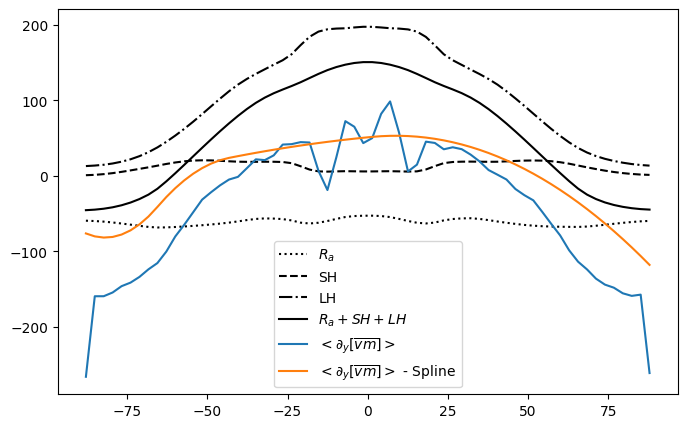

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8, 5), sharex=True)
ax.plot(ds.lat, R_a, label='$R_a$', color='k', linestyle=':')
ax.plot(ds.lat, ds_use.flux_t.mean(dim=['lon', 'time']), label='SH', color='k', linestyle='--')
ax.plot(ds.lat, ds_use.flux_lhe.mean(dim=['lon', 'time']), label='LH', color='k', linestyle='-.')
ax.plot(ds.lat, R_a + ds_use.flux_t.mean(dim=['lon', 'time']) + ds_use.flux_lhe.mean(dim=['lon', 'time']),
        color='k', label='$R_a + SH + LH$')
ax.plot(ds.lat, vm_integ_div, label='$<\\partial_y [\overline{vm}]>$')
ax.plot(ds.lat, vm_integ_div_spline, label='$<\\partial_y [\overline{vm}]>$ - Spline')
ax.legend();

From the above plot, we see that the equation $<\partial_y [\overline{vm}]> = R_a + SH + LH$ is not exactly satisfied, but with the spline it does a decent job.

This may be something to do how I integrated or differentiated e.g. not taking the correct pressure limits in the vertical integral. I think we expect convergence at bottom of atmosphere and divergence of MSE at top, so this may cause issues, if these don't cancel.

The blue line being bad at high latitudes is probably because you are dividing by $\cos(\phi)$ which is very small.

For actually getting the $R_1$ and $R_2$ values from now on, we infer $\partial_y(vm)$ from the residual as is done in the paper so equation 2 is always exactly satisfied.

### Sanity check of what `swdn_sfc` is
The plot below just shows that `swdn_sfc` is equal to the incident flux at the surface, ($e^{-\tau_{sw}} \times$ `swdn_toa`), which is equal to the flux incident at top of the atmosphere (`swdn_toa`) multiplied by the transmittance of the atmosphere ($e^{-\tau_{sw}}$).
The amount reflected by the surface ($\alpha \times$ incident flux) is then subtracted from this to give `swdn_sfc` = $(1-\alpha) e^{-\tau_{sw}} \times $ `swdn_toa`.

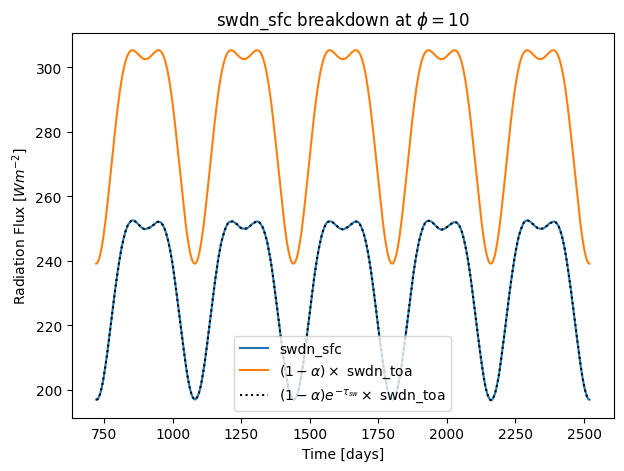

In [26]:
# Sanity check that swdn_sfc includes the albedo term
lat_plot = 10
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.plot(ds_use.time, ds_use.sel(lat=10, method='nearest').swdn_sfc.mean(dim='lon'), label='swdn_sfc')
ax.plot(ds_use.time, (1-albedo)*ds_use.sel(lat=lat_plot, method='nearest').swdn_toa.mean(dim='lon'), label='$(1-\\alpha) \\times$ swdn_toa')
ax.plot(ds_use.time, (1-albedo)*ds_use.sel(lat=lat_plot, method='nearest').swdn_toa.mean(dim='lon')*
        np.exp(-frierson_sw_optical_depth(ds_use.sel(lat=lat_plot, method='nearest').mean(dim='lon').ps, tau_sw)),
        label='$(1-\\alpha) e^{-\\tau_{sw}} \\times $ swdn_toa', linestyle=':', color='k')
ax.set_ylabel('Radiation Flux [$Wm^{-2}$]')
ax.set_xlabel('Time [days]')
ax.set_title(f'swdn_sfc breakdown at $\phi={lat_plot}$')
ax.legend();

## Figure 8b of Paper
Now we take the annual mean for the northern hemisphere mid-latitudes to see if we can replicate figure 8b of the paper.

In [27]:
lat_min = 40
lat_max = 60
ds_single_lat = ds_use.where((ds_use.lat <= lat_max) & (ds_use.lat >= lat_min), drop=True)
ds_single_lat = area_weight_mean_lat(ds_single_lat)
ds_single_lat = annual_mean(ds_single_lat).load()

Variables Averaged: ['temp', 'sphum', 'height', 'vcomp', 'olr', 'swdn_toa', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_t', 'flux_lhe', 'ps']


In [32]:
# Compute time gradient of MSE at each altitude - shape is n_time x n_p
from scipy.interpolate import BSpline, splrep
mse = moist_static_energy(ds_single_lat.temp, ds_single_lat.sphum, ds_single_lat.height).mean(dim='lon')*1000
dt = 24*60*60  # 1 day in seconds
# plt.plot(mse[0], ds_single_lat.pfull)
mse_integ = integrate.simpson(mse[:, 0:]/g, ds.pfull[0:]*100)
# When fitting spline, need to divide by a scaling factor otherwise very large and s variable does not do anything.
# In general, the lower s, the better the fit
spl_mse = UnivariateSpline(ds_single_lat.time, mse_integ/np.mean(mse_integ), s=0.001)
mse_integ_spline = spl_mse(ds_single_lat.time) * np.mean(mse_integ)
dm_dt_spline = spl_mse.derivative()(ds_single_lat.time)*np.mean(mse_integ)/(24*60*60)     # need to convert days into seconds
dm_dt = np.gradient(mse_integ, dt, axis=0)

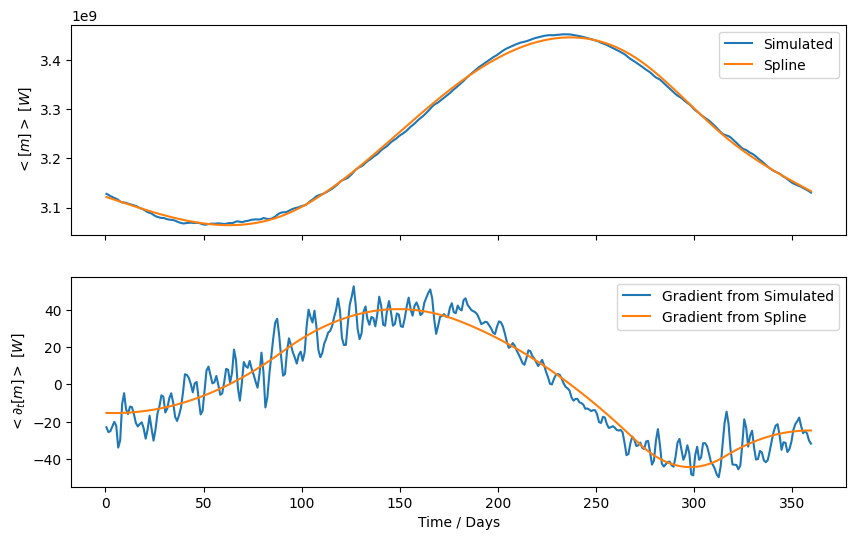

In [33]:
fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
ax[0].plot(ds_single_lat.time, mse_integ, label='Simulated')
ax[0].plot(ds_single_lat.time, mse_integ_spline, label='Spline')
ax[1].plot(ds_single_lat.time, dm_dt, label='Gradient from Simulated')
ax[1].plot(ds_single_lat.time, dm_dt_spline, label='Gradient from Spline')
ax[1].set_xlabel('Time / Days')
ax[0].set_ylabel('$<[m]>$ [$W$]')
ax[1].set_ylabel('$<\\partial_t [m]>$ [$W$]')
ax[0].legend()
ax[1].legend();

In [55]:
def get_R_a(dataset, albedo_const=albedo):
    return  dataset.swdn_toa - dataset.swdn_sfc / (1-albedo_const) + dataset.lwup_sfc - dataset.lwdn_sfc - dataset.olr

lh = ds_single_lat.flux_lhe.mean(dim=['lon'])
sh = ds_single_lat.flux_t.mean(dim=['lon'])
R_a = get_R_a(ds_single_lat).mean(dim=['lon'])
dvm_dy = R_a + lh + sh - dm_dt_spline

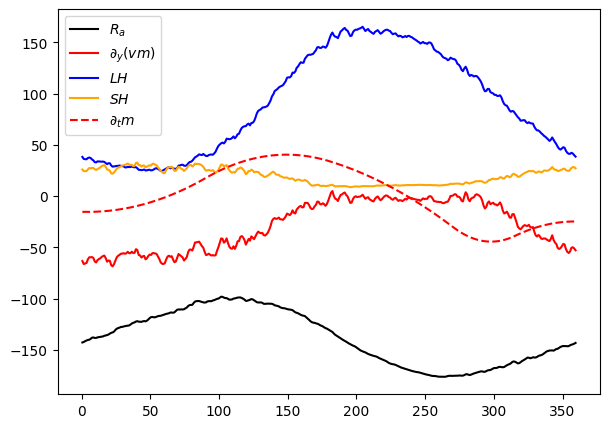

In [56]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.plot(ds_single_lat.time, R_a, color='k', label='$R_a$')
ax.plot(ds_single_lat.time, dvm_dy, color='r', label='$\partial_y(vm)$')
ax.plot(ds_single_lat.time, lh, color='b', label='$LH$')
ax.plot(ds_single_lat.time, sh, color='orange', label='$SH$')
ax.plot(ds_single_lat.time, dm_dt_spline, color='r', linestyle='--', label='$\partial_t m$')
ax.legend();

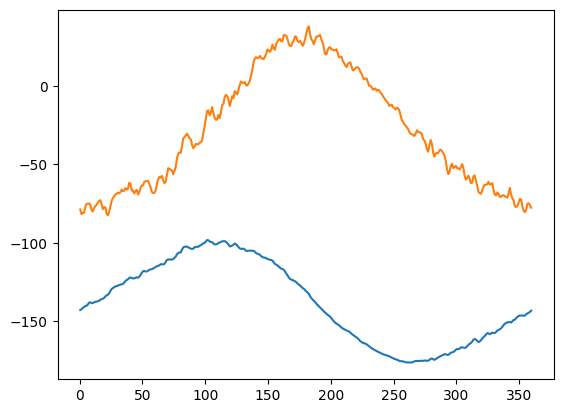

In [52]:
# plt.plot(ds_use.time, R_a)
# plt.plot(ds_use.time, ds_use.flux_t.mean(dim=['lon']))
# plt.plot(ds_use.time, ds_use.flux_lhe.mean(dim=['lon']))
# plt.plot(ds_use.time, dvm_dy)
plt.plot(ds_single_lat.time, R_a)
plt.plot(ds_single_lat.time, dvm_dy + dm_dt_spline)
# plt.ylim(-2,2)
# plt.plot(ds_use.time, R_a + ds_use.flux_t.mean(dim=['lon']) + ds_use.flux_lhe.mean(dim=['lon']), color='k', linestyle=':')

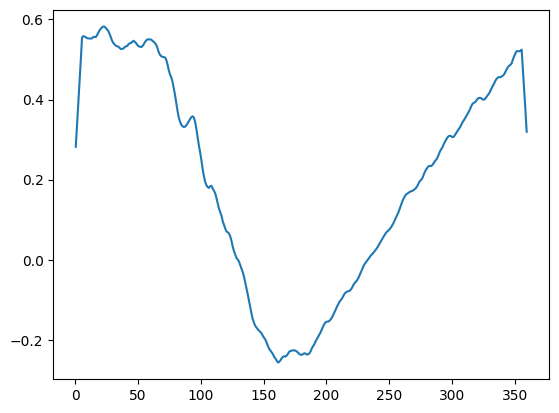

In [54]:
plt.plot(ds_single_lat.time, np.convolve((dvm_dy + dm_dt_spline)/R_a, np.ones(10)/10, 'same'))